## Описание проекта

В нашем распоряжении данные с текстами правок. Нужно построить модель, которая бы смогла их классифицировать: негативные или позитивные. Успешным будем считать, если на тестовой выборке метрика `F1` не меньше 0.75

In [1]:
# !pip install --ignore-installed PyYAML
# !pip install transformers[torch]
# !pip install pymorphy2[fast]
# !pip install imblearn

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, \
                            confusion_matrix, \
                            ConfusionMatrixDisplay, \
                            classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from tqdm import notebook
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import torch
import transformers
import spacy
import re
from string import punctuation
from nltk.corpus import stopwords
import nltk
from nltk.probability import FreqDist
import random
from tqdm import tqdm

In [3]:
nltk.download("stopwords")
nltk.download("punkt")
tqdm.pandas()
random.seed(42)
#random_state = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Igor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Igor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
data = pd.read_csv('datasets/toxic_comments.csv', index_col=[0])

In [5]:
data.head(3)

text  toxic
0  Explanation\nWhy the edits made under my usern...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


## Предобработка данных

Посмотрим на баланс классов

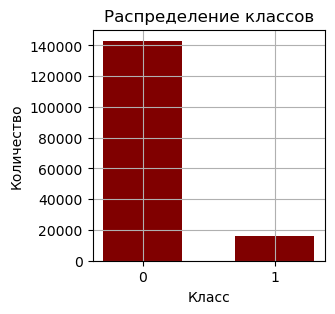

In [7]:
count_zero = data['toxic'].value_counts()[0]
count_first = data['toxic'].value_counts()[1]

fig = plt.figure(figsize=(3,3))
labels = ['0', '1']
plt.bar(labels, [count_zero, count_first],
        color='maroon', width=0.6)
plt.grid()
plt.title("Распределение классов")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()

Здесь явно есть дисбаланс классов. Учтем это при обучении модели

In [8]:
# num_zero_class = data['toxic'].value_counts().iloc[0]
# num_one_class = data['toxic'].value_counts().iloc[1]

# zero_df = data[data['toxic'] == 0]
# one_df = data[data['toxic'] == 1]
# balanced_zero_df = zero_df.sample(num_one_class, replace=False)
# data = pd.concat([balanced_zero_df, one_df])

Все используемы шаги будем добавлять в Pipeline

In [9]:
steps = []

В данном проекте решим задачу с помощью библиотеки **sklearn**, используя модель *LogisticRegression*, а также сравним результат с **RuBERT**

In [10]:
eng_stopwords = stopwords.words("english")
eng_stopwords.extend(['you', 'I'])
lemma = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [11]:
def processing_text(text):
    delete_stopw = " ".join([i for i in text.lower().split() if i not in eng_stopwords])
    delete_punct = ''.join([i for i in delete_stopw if i not in punctuation])
    clear_text = " ".join(re.sub(r'[^A-Za-z]', ' ', delete_punct).split())
    
    st1 = lemma(clear_text)
    to_norm_form = " ".join([token.lemma_ for token in st1])
    
    return to_norm_form

# def pipe_processing_text(X, y=None):
#     X = X.copy(deep=True)
#     delete_stopw = lambda x: " ".join([i for i in x.lower().split() if i not in eng_stopwords])
#     delete_punct = lambda x: ''.join([i for i in x if i not in punctuation])
#     clear_text = lambda x: " ".join(re.sub(r'[^A-Za-z]', ' ', x).split())
#     st1 = lambda x: lemma(x)
#     to_norm_form = lambda x: " ".join([token.lemma_ for token in x])
    
#     X = X.apply(delete_stopw)
#     X = X.apply(delete_punct)
#     X = X.apply(clear_text)
#     X = X.apply(st1)
#     X = X.apply(to_norm_form)
#     return X

In [12]:
#steps.append(tuple(("proc_text", FunctionTransformer(pipe_processing_text))))

In [13]:
data['text'] = data['text'].progress_apply(processing_text)

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [14:45<00:00, 179.87it/s]


Разделение на выборки

In [14]:
data.head(2)

text  toxic
0  explanation edit make username hardcore metall...      0
1  daww match background colour I m seemingly stu...      0

Чтобы понять основную тематику сообщений, проведем частотный анализ слов

In [15]:
toxic_data = data[data['toxic'] == 1]
words_toxic = ' '.join([word for word in toxic_data['text']])
tokenized_toxic = nltk.word_tokenize(words_toxic)

non_toxic_data = data[data['toxic'] == 0]
words_non_toxic = ' '.join([word for word in non_toxic_data['text']])
tokenized_non_toxic = nltk.word_tokenize(words_non_toxic)

In [16]:
fdist_toxic = FreqDist(tokenized_toxic)
fdist_non_toxic = FreqDist(tokenized_non_toxic)

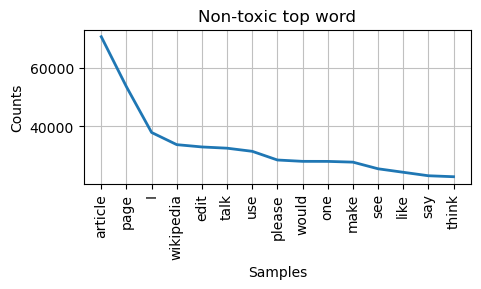

In [17]:
fig = plt.figure(figsize=(5,2))
plt.title("Non-toxic top word")
fdist_non_toxic.plot(15, cumulative=False)
plt.show()

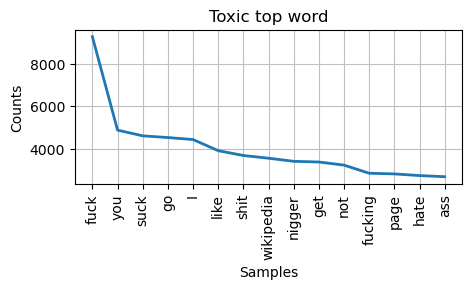

In [18]:
fig = plt.figure(figsize=(5,2))
plt.title("Toxic top word")
fdist_toxic.plot(15, cumulative=False)
plt.show()

In [19]:
del toxic_data
del non_toxic_data

### Разделение данных

In [20]:
features = data['text']
target = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(features,
                                                   target,
                                                   test_size=0.25,
                                                   stratify=target,
                                                   shuffle=True)

In [21]:
X_train.shape, y_train.shape

((119469,), (119469,))

In [22]:
X_test.shape, y_test.shape

((39823,), (39823,))

Для обучения *LogisticRegression* подготовим признаки из очищенного текста. Для этого подсчитаем матрицу **TF-IDF** для каждого слова в корпусе

In [23]:
steps.append(tuple(("tfidf_vect", TfidfVectorizer())))

## Обучение модели

### LogisticRegression

In [24]:
steps.append(tuple(("model", LogisticRegression())))

params = {
    'model__C' : [.01, .05, .1, .5],
    'tfidf_vect__ngram_range' : [(2,2), (3,3), (1,2)]
}

pipe = Pipeline(steps)

Учтем дисбаланс классов при выборе метрики в GS

In [25]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    cv=5,
    verbose=10,
    scoring='f1',
    n_jobs=-1,
    error_score='raise'
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfidf_vect', TfidfVectorizer()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.05, 0.1, 0.5],
                         'tfidf_vect__ngram_range': [(2, 2), (3, 3), (1, 2)]},
             scoring='f1', verbose=10)

Результат на валидации

In [26]:
grid.best_score_

0.6259127577286692

In [27]:
grid.best_params_

{'model__C': 0.5, 'tfidf_vect__ngram_range': (1, 2)}

In [28]:
lreg_pred = grid.predict(X_test)
metric = f1_score(y_test, lreg_pred)

In [29]:
metric

0.6546223958333334

Посмотрим на матрицу ошибок

In [30]:
cm = confusion_matrix(y_test, lreg_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=grid.classes_)
disp.plot()
plt.title("Confusion-matrix")
plt.show()

In [31]:
target_names = ['non-toxic', 'toxic']
print(classification_report(y_test, lreg_pred, target_names=target_names))

              precision    recall  f1-score   support

   non-toxic       0.95      1.00      0.97     35777
       toxic       0.96      0.50      0.65      4046

    accuracy                           0.95     39823
   macro avg       0.95      0.75      0.81     39823
weighted avg       0.95      0.95      0.94     39823



Теперь посмотрим, что можно сделать с предобученной BERT моделью

### BERT

In [32]:
data = data.sample(frac=1)
data_batch = data[:2000]
data_batch.reset_index(drop=True, inplace=True)
target = data_batch['toxic']

In [33]:
torch.cuda.is_available()

True

In [34]:
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')
tokenized = data_batch['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True,
                               truncation=True)
)

model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
model.to("cuda")

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [35]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

In [36]:
padded.shape[0]

2000

In [37]:
batch_size = 100
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.cuda.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.cuda.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:])

  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\Igor\AppData\Local\Temp\ipykernel_23044\2335465630.py:5: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:85.)
  batch = torch.cuda.LongTensor(padded[batch_size*i:batch_size*(i+1)])


In [38]:
embeddings = np.array([i.cpu().numpy() for i in embeddings])
features = np.concatenate(embeddings)

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                   test_size=0.4)

In [39]:
lreg_bert = LogisticRegression()
lreg_bert.fit(X_train, y_train)

C:\Users\Igor\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [40]:
pred_bert = lreg_bert.predict(X_test)
metric_bert = f1_score(y_test, pred_bert)

In [41]:
metric_bert

0.8350515463917526

## Выводы

Мы обучили модель логистической регресии с использованием техники TF-IDF и достигли необходимой метрики. Аналогичная модель, построенная на векторном представлении BERT показала более лучший результат. 